# **PCOS Prediction Using Machine Learning**


Predicting Polycystic Ovary Syndrome (PCOS) from patient health records using Random Forest and feature engineering.


## Step 1: Import libraries


In [9]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# For handling imbalanced data
from imblearn.over_sampling import SMOTE


## Step 2: Load Dataset
- Loaded PCOS dataset and checked shape, columns, and missing values.
- Ensures correct data types and identifies potential data issues early.


In [11]:
data = pd.read_csv("../data/PCOS_infertility.csv", encoding="latin1")

# Checking the first few rows
print("Shape of dataset:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

print("\nColumn info:")
print(data.info())

print(data.columns.tolist())

Shape of dataset: (541, 6)

First 5 rows:
   Sl. No  Patient File No.  PCOS (Y/N)    I   beta-HCG(mIU/mL)  \
0       1             10001           0                    1.99   
1       2             10002           0                   60.80   
2       3             10003           1                  494.08   
3       4             10004           0                    1.99   
4       5             10005           0                  801.45   

   II    beta-HCG(mIU/mL) AMH(ng/mL)  
0                    1.99       2.07  
1                    1.99       1.53  
2                  494.08       6.63  
3                    1.99       1.22  
4                  801.45       2.26  

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null   

## Step 3: Data Cleaning
- Cleaned column names, converted AMH to numeric, handled missing values.
- Dropped unnecessary columns to keep dataset relevant for modeling.


In [13]:
# Strip spaces from column names
data.columns = data.columns.str.strip()

# Rename columns to simpler names
data = data.rename(columns={
    "PCOS (Y/N)": "PCOS",
    "I   beta-HCG(mIU/mL)": "beta_HCG_I",
    "II    beta-HCG(mIU/mL)": "beta_HCG_II",
    "AMH(ng/mL)": "AMH"
})

# Convert AMH to numeric (coerce errors to NaN)
data["AMH"] = pd.to_numeric(data["AMH"], errors='coerce')

# Drop unnecessary columns
data = data.drop(["Sl. No", "Patient File No."], axis=1)

# ✅ Handle missing value in AMH
data["AMH"] = data["AMH"].fillna(data["AMH"].median())

print("Cleaned columns:", data.columns.tolist())
print(data.info())
print(data.head())


Cleaned columns: ['PCOS', 'beta_HCG_I', 'beta_HCG_II', 'AMH']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PCOS         541 non-null    int64  
 1   beta_HCG_I   541 non-null    float64
 2   beta_HCG_II  541 non-null    float64
 3   AMH          541 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 17.0 KB
None
   PCOS  beta_HCG_I  beta_HCG_II   AMH
0     0        1.99         1.99  2.07
1     0       60.80         1.99  1.53
2     1      494.08       494.08  6.63
3     0        1.99         1.99  1.22
4     0      801.45       801.45  2.26


## Step 4: Exploratory Data Analysis
- Visualized PCOS distribution, hormone levels, and feature correlations.
- Helps identify patterns and relationships for better feature selection.


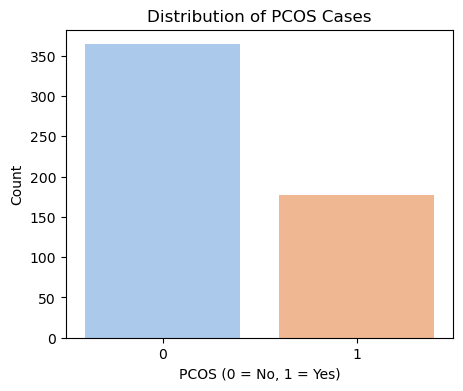

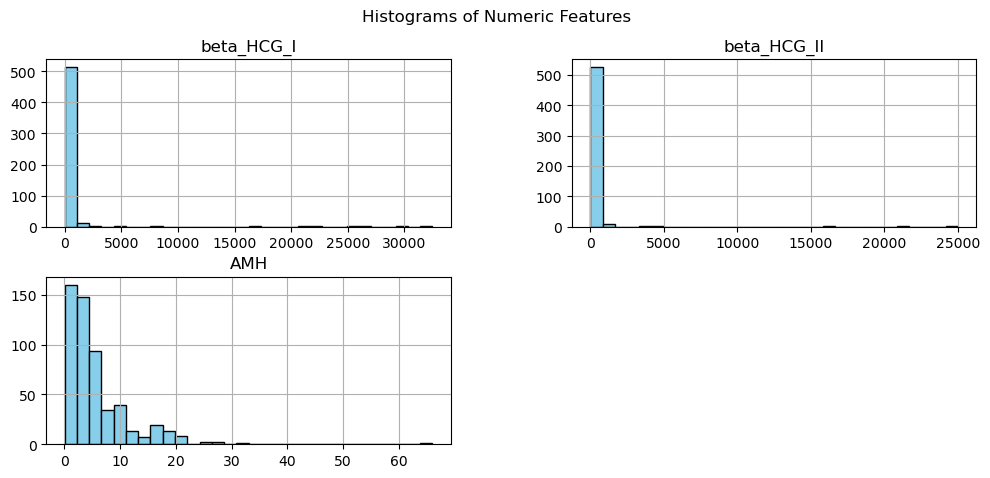

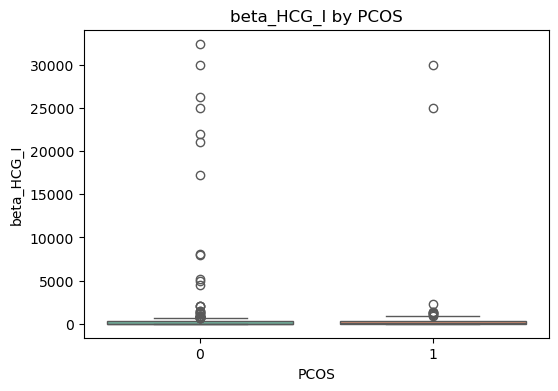

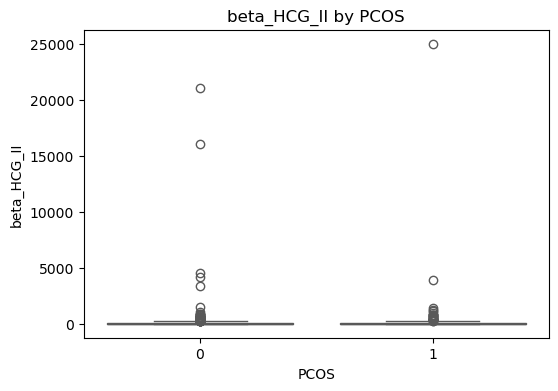

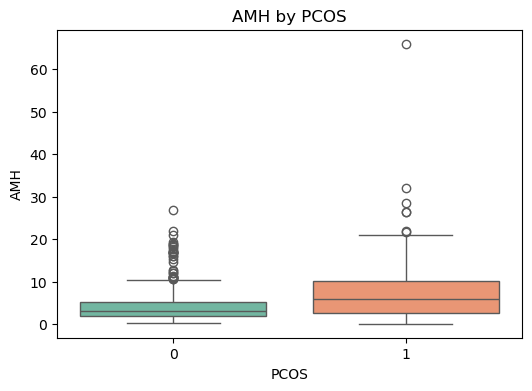

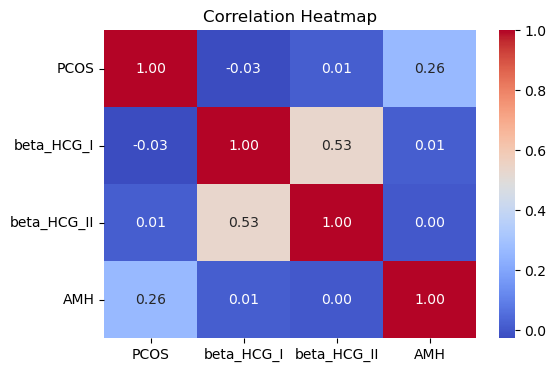

In [18]:
# 1. Distribution of target variable (PCOS)
plt.figure(figsize=(5,4))
sns.countplot(x="PCOS", data=data, hue="PCOS", palette="pastel", legend=False)
plt.title("Distribution of PCOS Cases")
plt.xlabel("PCOS (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# 2. Histograms for numerical features
data[["beta_HCG_I", "beta_HCG_II", "AMH"]].hist(bins=30, figsize=(12,5), color="skyblue", edgecolor="black")
plt.suptitle("Histograms of Numeric Features")
plt.show()

# 3. Boxplots to compare distributions by PCOS
for col in ["beta_HCG_I", "beta_HCG_II", "AMH"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="PCOS", y=col, data=data, hue="PCOS", palette="Set2", legend=False)
    plt.title(f"{col} by PCOS")
    plt.show()

# 4. Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## Step 5: Feature Engineering & Data Preprocessing
### Feature Engineering:
- Created beta_HCG_ratio and processed categorical variables.
- Extracted meaningful patterns to boost model performance.
### Data Preprocessing:
- Train-test split, standardization, and SMOTE for class imbalance.
- Ensures balanced, normalized input for robust model training.

In [21]:
# Features and target
X = data.drop("PCOS", axis=1)
y = data["PCOS"]

# Optional: Create new feature
X['beta_HCG_ratio'] = X['beta_HCG_II'] / (X['beta_HCG_I'] + 1)  # avoid division by 0

# Handle categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

# Save feature names (important for later feature importance plots)
feature_names = X.columns.tolist()

# split dataset (stratify ensures class proportion is maintained)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Standardize numeric features (after SMOTE!)
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# Check new class distribution
print("Original y_train distribution:\n", pd.Series(y_train).value_counts())
print("Resampled y_train distribution:\n", pd.Series(y_train_res).value_counts())


Original y_train distribution:
 PCOS
0    291
1    141
Name: count, dtype: int64
Resampled y_train distribution:
 PCOS
0    291
1    291
Name: count, dtype: int64


## Step 6: Model Building
- Trained Random Forest classifier as baseline model.
- Captures non-linear patterns in hormonal and lifestyle features.


In [24]:
# Initialize model
model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)

# Train model on resampled data
model.fit(X_train_res, y_train_res)

# Predictions
y_pred = model.predict(X_test)

## Step 7: Model Evaluation
- Evaluated accuracy, confusion matrix, classification report, and ROC-AUC.
- Ensures model reliability and balanced predictions.


Accuracy: 0.6513761467889908


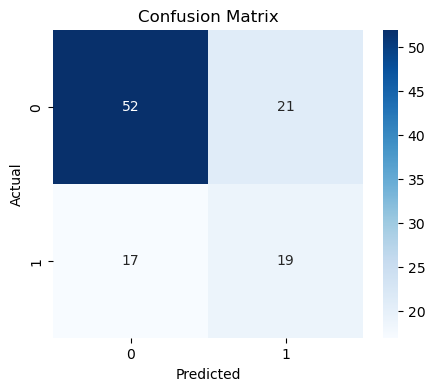

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73        73
           1       0.47      0.53      0.50        36

    accuracy                           0.65       109
   macro avg       0.61      0.62      0.62       109
weighted avg       0.66      0.65      0.66       109



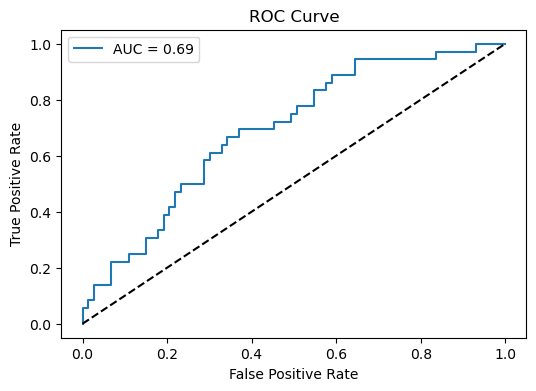

In [27]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Confusion matrix (visualized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve and AUC
y_prob = model.predict_proba(X_test)[:,1]  # probability estimates for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Step 8: Feature Importance
- Identified top predictors (AMH, beta_HCG) using Random Forest.
- Highlights features most influencing PCOS prediction.


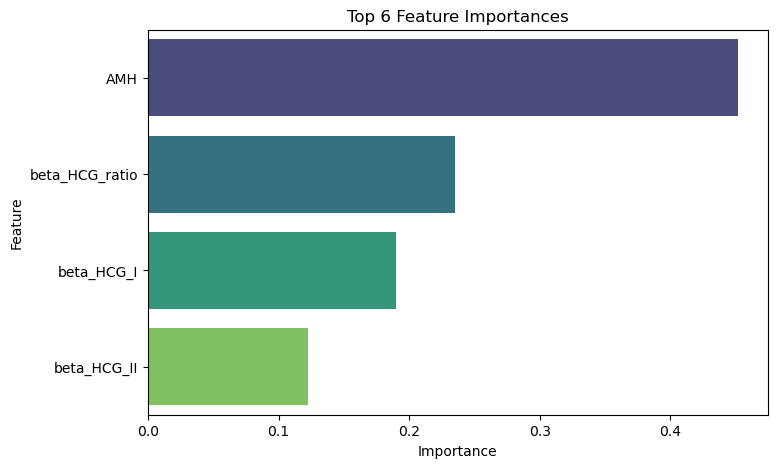

In [30]:
# Log-transform skewed numeric features for clearer importance
numeric_features = ["beta_HCG_I", "beta_HCG_II", "AMH"]
X_plot = X.copy()
for col in numeric_features:
    X_plot[col] = np.log1p(X_plot[col].clip(lower=0))

# Train model on full dataset (important: align X_plot with y)
model.fit(scaler.fit_transform(X_plot), y)

# Get feature importances
importances = model.feature_importances_
feature_names = X_plot.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 6 features only for clarity
top_features = feat_imp.head(6)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", dodge=False, legend=False)
plt.title("Top 6 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Step 9: Hyperparameter Tuning
- Optimized Random Forest parameters with RandomizedSearchCV.
- Improved ROC-AUC and ensured robust predictions.


In [33]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized Search
rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
rs.fit(X_train_res, y_train_res)

# Best parameters
print("Best Hyperparameters:", rs.best_params_)

# Train Random Forest with best parameters
best_rf = rs.best_estimator_

# Predictions
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:,1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Accuracy: 0.6788990825688074
ROC-AUC: 0.6883561643835616


## Step 10: Feature Interpretation
- Visualized top 6 features post-tuning for model explainability.
- Confirms key hormonal and lifestyle indicators driving predictions.


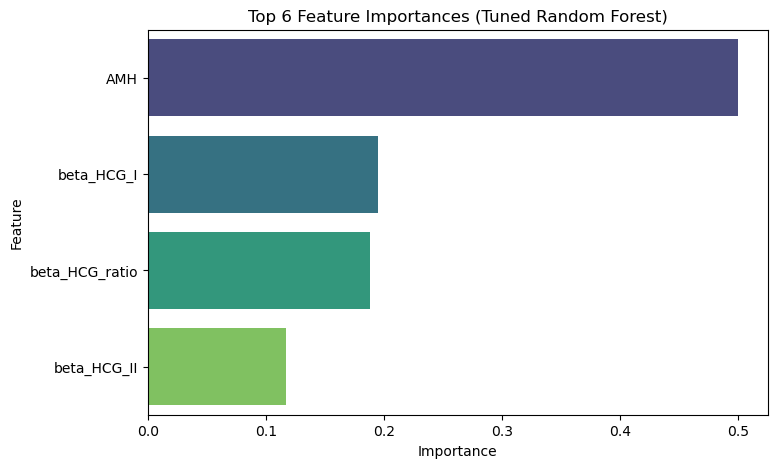

All Feature Importances:
AMH               0.500354
beta_HCG_I        0.194633
beta_HCG_ratio    0.187777
beta_HCG_II       0.117236
dtype: float64


In [35]:
# Use the best Random Forest from Step 9.1
feature_importances = pd.Series(best_rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot top 6 features
top_features = feature_importances.head(6)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis", hue=top_features.index, legend=False)
plt.title("Top 6 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Optional: Display all feature importances in a table
print("All Feature Importances:")
print(feature_importances)


In [38]:
import os

# Create 'app' folder if it doesn't exist
if not os.path.exists("app"):
    os.makedirs("app")


In [43]:
import joblib
import os

# Path to app folder (relative to notebook)
APP_FOLDER = "../app"

# Save the trained Random Forest model
joblib.dump(best_rf, os.path.join(APP_FOLDER, "best_rf_model.pkl"))

# Save the StandardScaler
joblib.dump(scaler, os.path.join(APP_FOLDER, "scaler.pkl"))

print("Model and scaler saved successfully in 'app/' folder.")


Model and scaler saved successfully in 'app/' folder.
